What now?

We create two tables with the following data:

# Table 1
- Based on basic data in `~/data/trd/crosses_info.csv`, we want to know 
    - number of loci with
        - TRD
        - of these
            - positive, negative outlier
                - pi
                - fst
                - dxy
                - LD
                - local phylogeny data
                - dn/ds
            - SVs
                - for each SV type, count of loci that overlap with these
            - repetitive elements
                - % region in rep. bp

# Table 2
- All individual TRD loci data, with per locus
    - percentile values for
        - pi
        - fst
        - dxy
        - LD
        - local phylogeny data
        - dn/ds
    - SVs, each type
        - % of loci overlapping with called SV
    - rep elements, each type
        - % locus

In [2]:
library(tidytable)


Attaching package: 'tidytable'


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%




In [3]:
# merge data from the different analysis to a per-TRD-locus table

# local phylogeny

LP_file<-"/home/jnrunge/data/trd/local_phylogenies_trd_analysis/TRD_regions_with_LP_data.csv.gz"
One_Table<-fread(LP_file)


# SVs

SV_files<-list.files("/home/jnrunge/data/trd/SV_analysis",
                    "SV_data.RDS$", full.names=TRUE)
SV_data<-data.table()
for(f in SV_files){
    SV_data<-bind_rows(SV_data, readRDS(f))
}
SV_data_summary<-SV_data%>%filter(!is.na(TYPE))%>%
group_by(cross,ID,TYPE,source)%>%summarize(sum_LEN_rel=sum(LEN_rel))

head(SV_data_summary)

cross,ID,TYPE,source,sum_LEN_rel
<chr>,<int>,<chr>,<chr>,<dbl>
ChrisC4,2,CPG,Syri,0.0002838751
ChrisC4,2,CPL,Syri,0.0021584739
ChrisC4,2,DEL,Syri,0.0015319027
ChrisC4,2,DEL,VictorSV,0.0144085807
ChrisC4,2,DUP,Syri,0.0073679661
ChrisC4,2,DUP,VictorSV,0.0012480276


In [25]:
head(One_Table)

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,0.2969131,-0.2684897,0.7760687,0.13054090,0.002613891,-1.064328,0.3706375,-0.2958096,0.7552774,0.21832468
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684,0.3225841,-0.2627496,0.4929458,-0.13252233,0.000000000,-1.363081,0.2661504,-0.3312193,0.4711997,-0.17939273
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,0.6407128,-0.1538972,0.5699586,-0.07256862,0.000000000,-2.162405,0.6559881,-0.1596002,0.5550016,-0.08543913
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,0.4783070,-0.2221963,0.6000849,-0.04848805,0.000000000,-1.508294,0.5172377,-0.2397347,0.6371062,0.01428794
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,0.7185743,-0.1962318,0.4565609,-0.24634727,0.000000000,-1.622491,0.8709027,1.3968420,0.8402461,0.48016916
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,0.1547682,-0.3987494,0.5707012,-0.08650142,0.000000000,-1.294373,0.2846080,-0.4131060,0.6197093,-0.33877109


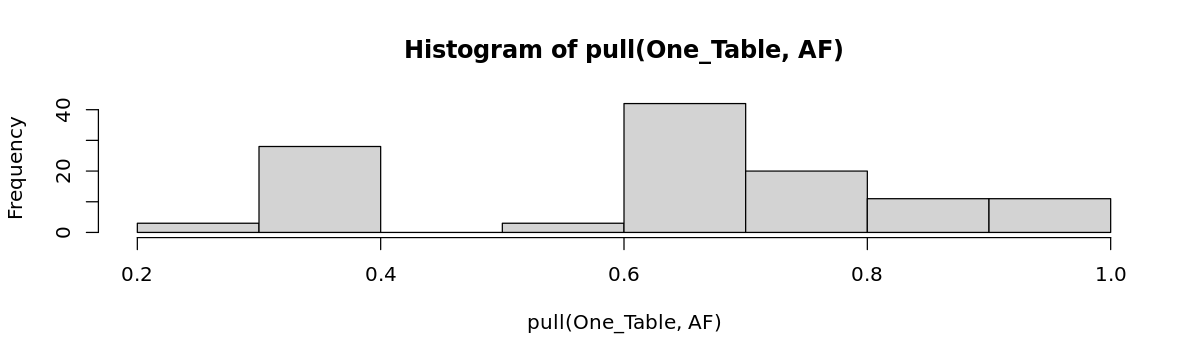

In [33]:
# we need to know which direction the distortion is and how strong it is
# to distinguish different cases

# just add AF to all TRD regions

One_Table<-mutate(One_Table, AF=NA)

for(i in 1:nrow(One_Table)){
    OT_slice<-slice(One_Table, i)
    AF_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",pull(OT_slice, cross),"-AF.csv.gz")
    AF<-fread(AF_file)
    AF<-filter(AF, chr==pull(OT_slice,chr) & global_pos >= pull(OT_slice, global_start) & global_pos <= pull(OT_slice, global_end))
    AF_value<-mean(pull(AF,AD_A1)/pull(AF,sumCount))
    One_Table<-mutate(One_Table, AF=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),
                                           AF_value, AF))
}

hist(pull(One_Table, AF))

In [34]:
One_Table<-mutate(One_Table, Distorter=ifelse(AF>0.5,"1","2"))

In [8]:
summary(SV_data_summary)

    cross                 ID             TYPE              source         
 Length:233         Min.   : 1.000   Length:233         Length:233        
 Class :character   1st Qu.: 2.000   Class :character   Class :character  
 Mode  :character   Median : 4.000   Mode  :character   Mode  :character  
                    Mean   : 7.957                                        
                    3rd Qu.: 7.000                                        
                    Max.   :64.000                                        
  sum_LEN_rel        
 Min.   :-0.0000592  
 1st Qu.: 0.0010659  
 Median : 0.0026474  
 Mean   : 0.0770976  
 3rd Qu.: 0.0107215  
 Max.   : 1.6582373  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


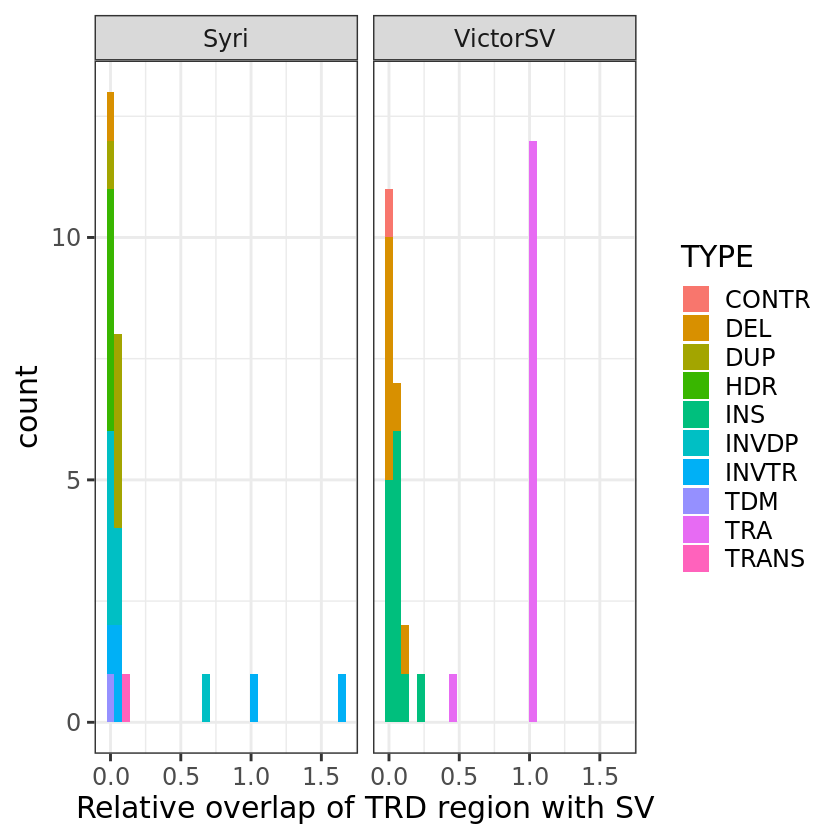

In [10]:
library(ggplot2)
ggplot(SV_data_summary%>%filter(sum_LEN_rel>=0.01), aes(sum_LEN_rel, fill=TYPE))+
geom_histogram()+
facet_wrap(~source)+#+scale_y_log10()
theme_bw(18)+
xlab("Relative overlap of TRD region with SV")

In [47]:
One_Table <- One_Table %>% 
  group_by(cross) %>%
  mutate(strongest = abs(AF - 0.5) == max(abs(AF - 0.5), na.rm = TRUE)) %>%
  ungroup()

       ID          lengthSNPs         chr             global_start     
 Min.   : 1.00   Min.   : 106.0   Length:118         Min.   :   81442  
 1st Qu.: 3.00   1st Qu.: 230.8   Class :character   1st Qu.: 3137850  
 Median : 6.00   Median : 424.0   Mode  :character   Median : 6695870  
 Mean   :10.55   Mean   : 703.8                      Mean   : 6342821  
 3rd Qu.:13.00   3rd Qu.: 800.0                      3rd Qu.: 9451744  
 Max.   :64.00   Max.   :9553.0                      Max.   :11572861  
                                                                       
   global_end          lengthBp         cross               start        
 Min.   :  193807   Min.   : 50061   Length:118         Min.   :   2865  
 1st Qu.: 3292261   1st Qu.:100633   Class :character   1st Qu.:  65696  
 Median : 6823260   Median :160398   Mode  :character   Median : 260327  
 Mean   : 6551766   Mean   :208944                      Mean   : 306130  
 3rd Qu.: 9697528   3rd Qu.:277874                    

In [ ]:
plot(tree_changes_raw~lengthBp, One_Table)


	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_quantile") %>% pull(value)
t = 0.2549, df = 227.29, p-value = 0.799
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05615114  0.07283717
sample estimates:
mean of x mean of y 
 0.579512  0.571169 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_quantile") %>% pull(value)
t = -0.35741, df = 230.86, p-value = 0.7211
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.08049299  0.05577403
sample estimates:
mean of x mean of y 
0.5456912 0.5580507 


Distorter,name,value
<lgl>,<chr>,<dbl>
FALSE,PCA_eucldist_quantile,0.2969131
TRUE,PCA_eucldist_quantile,0.3225841
FALSE,PCA_eucldist_quantile,0.6407128
FALSE,PCA_eucldist_quantile,0.4783070
TRUE,PCA_eucldist_quantile,0.7185743
FALSE,PCA_eucldist_quantile,0.1547682


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 5 rows containing non-finite values (`stat_bin()`)."



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_quantile") %>% pull(value)
t = -0.11859, df = 58.939, p-value = 0.906
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1450730  0.1288396
sample estimates:
mean of x mean of y 
0.5824382 0.5905549 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_quantile") %>% pull(value)
t = -0.67601, df = 58.567, p-value = 0.5017
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.16577166  0.08205878
sample estimates:
mean of x mean of y 
0.5823493 0.6242057 


Distorter,name,value
<lgl>,<chr>,<dbl>
FALSE,PCA_eucldist_quantile,0.6407128
TRUE,PCA_eucldist_quantile,0.7185743
FALSE,PCA_eucldist_quantile,0.7584597
FALSE,PCA_eucldist_quantile,0.7545348
TRUE,PCA_eucldist_quantile,0.5187228
TRUE,PCA_eucldist_quantile,0.2833351


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 5 rows containing non-finite values (`stat_bin()`)."


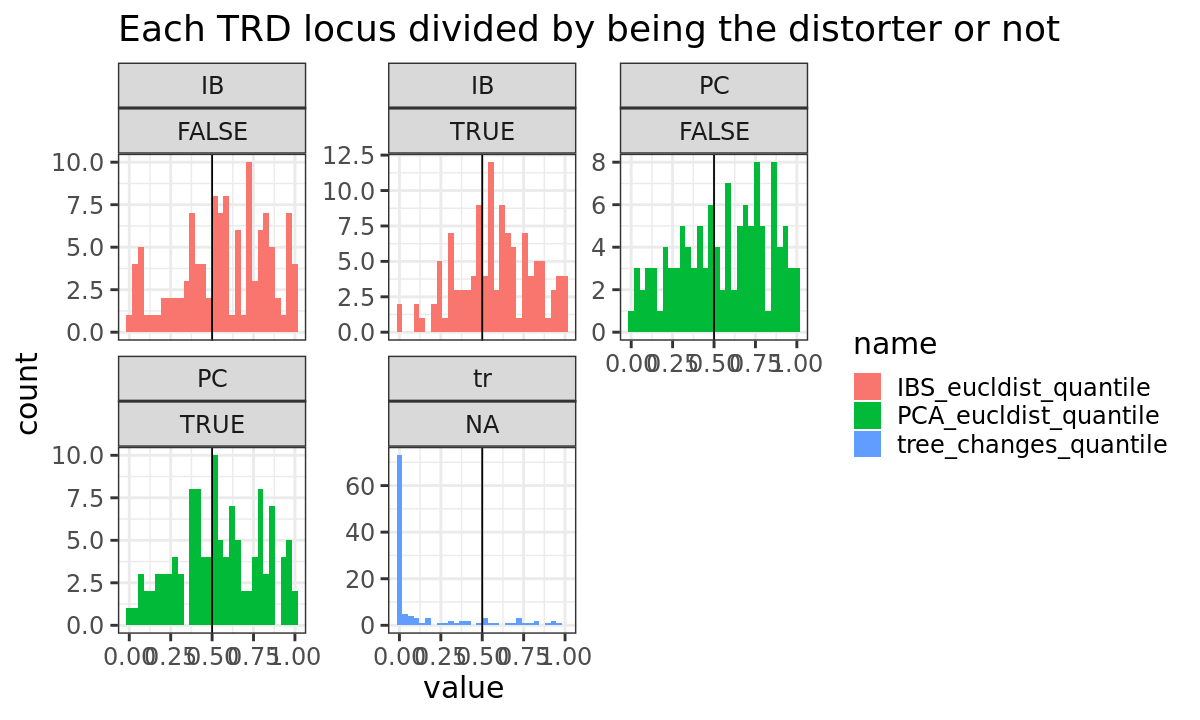

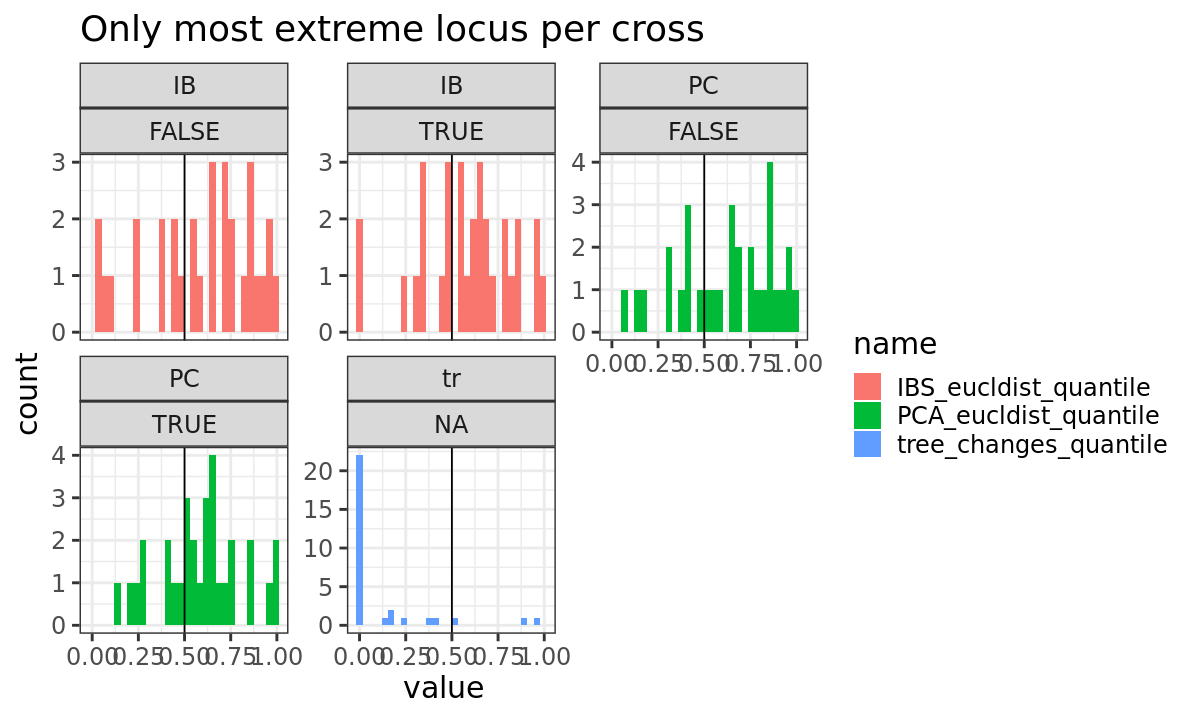

In [56]:
options(repr.plot.width=10, repr.plot.height=6)

# need to add information on 
# 1) each TRD spot, direction
# 2) overall which TRD spot is the main one + direction
# 3) normalize all values for comparability
# -- but the normalization should just be 0 = theoretical mean, meaning only change quantile to -0.5

library(stringr)

LP_colnames=c("PCA_eucldist_quantile_1","PCA_eucldist_sd_multiplier_1","IBS_eucldist_quantile_1","IBS_eucldist_sd_multiplier_1","tree_changes_quantile","tree_changes_sd_multiplier","PCA_eucldist_quantile_2","PCA_eucldist_sd_multiplier_2","IBS_eucldist_quantile_2","IBS_eucldist_sd_multiplier_2")
LP_colnames=LP_colnames[grepl("quant",LP_colnames,fixed=TRUE)]
LP_summary<-pivot_longer(One_Table%>%select(Distorter, all_of(LP_colnames)), cols = LP_colnames)
LP_summary <- LP_summary %>% mutate(Distorter = case_when(
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") & 
    substr(name, nchar(name), nchar(name)) == Distorter ~ TRUE,
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") ~ FALSE,
  TRUE ~ NA_real_
))
LP_summary <- LP_summary %>% mutate(name = str_remove(name, "_[12]$"))

t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)

head(LP_summary)
ggplot(LP_summary, aes(value,fill=name))+
geom_histogram(position="dodge")+geom_vline(xintercept=0.5)+
facet_wrap(~substr(name,1,2)+Distorter,scales="free_y")+theme_bw(18)+ggtitle("Each TRD locus divided by being the distorter or not")


# now only the strongest distorters

LP_summary<-pivot_longer(One_Table%>%filter(strongest)%>%select(Distorter, all_of(LP_colnames)), cols = LP_colnames)
LP_summary <- LP_summary %>% mutate(Distorter = case_when(
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") & 
    substr(name, nchar(name), nchar(name)) == Distorter ~ TRUE,
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") ~ FALSE,
  TRUE ~ NA_real_
))
LP_summary <- LP_summary %>% mutate(name = str_remove(name, "_[12]$"))
t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
head(LP_summary)
ggplot(LP_summary, aes(value,fill=name))+
geom_histogram(position="dodge")+geom_vline(xintercept=0.5)+
facet_wrap(~substr(name,1,2)+Distorter,scales="free_y")+theme_bw(18)+ggtitle("Only most extreme locus per cross")

After creating those tables, we should also create a PDF report for each region.

---
title: "Analysis of Genome Region"
output: pdf_document
---

## Introduction

This is a report on the analysis of genome region `r region_name`.

## Histogram of Variable

```{r}
ggplot(data, aes(x = variable)) +
  geom_histogram() +
  labs(title = paste("Histogram of", variable)) +
  theme_minimal()



rmarkdown::render("path/to/your/file.Rmd", params = list(region_name = region_name))
````

In [15]:
cross<-"YJNRC18"

In [59]:
SV_data%>%filter(ID==3 & source == "Syri") %>% arrange(-LEN_rel)

cross,ID,TYPE,LEN_rel,source,LEN
<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>
YJNRC18,3,INVTR,0.07866849,Syri,24883
YJNRC18,3,TRANS,0.07473870,Syri,23640
YJNRC18,3,INVTR,0.07365429,Syri,23297
YJNRC18,3,TRANS,0.05032532,Syri,15918
YJNRC18,3,INVTR,0.04995542,Syri,15801
YJNRC18,3,INVDP,0.04276293,Syri,13526
YJNRC18,3,DUP,0.03901967,Syri,12342
YJNRC18,3,TRANS,0.03798269,Syri,12014
YJNRC18,3,HDR,0.03527641,Syri,11158


In [62]:
rmarkdown::render("03_RegionReportTemplate.Rmd", params = 
                  list(cross=cross),
                  output_file = paste0("~/TRD/03_GenomicSignals/PDF_reports/",cross, '.HTML'), 
                 )



processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                   


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC18.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --variable bs3=TRUE --section-divs --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --mathjax --variable 'mathjax-url=https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --include-in-header /tmp/Rtmp5gHEF4/rmarkdown-str13369189b854d.html 



Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC18.HTML

